#**Importing and installing *necessary libraries***

In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.3/166.8 GB disk)


In [2]:
from ultralytics import YOLO

from IPython.display import display, Image

#**Getting data**

In [3]:
import os
HOME = os.getcwd()

!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
from google.colab import userdata
rf = Roboflow(api_key=userdata.get('API_KEY'))
project = rf.workspace("robouserflow").project("vegetables_v3")
dataset = project.version(11).download("yolov8")

project = rf.workspace("testveg").project("test-veg")
dataset = project.version(1).download("yolov8")

/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
loading Roboflow


Extracting Dataset Version Zip to Vegetables_v3-11 in yolov8:: 100%|██████████| 20386/20386 [00:03<00:00, 6793.82it/s]

loading Roboflow workspace...


loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.9, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to test-veg-1 in yolov8:: 100%|██████████| 12934/12934 [00:01<00:00, 7425.95it/s]


#**Preparing data**

In [4]:
## Merging multiple datasets and setting a directory flow for yolo

import os
import shutil

%cd {HOME}

# Specify the paths to the source directories
source_dir1 = "/content/datasets/Vegetables_v3-11"
source_dir2 = "/content/datasets/test-veg-1"

# Specify the path to the destination directory
dest_dir = "datasets"

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
  os.makedirs(dest_dir)

# Loop through the subfolders in each source directory
for subfolder in ["train", "test", "valid"]:
  path1 = os.path.join(source_dir1, subfolder)
  path2 = os.path.join(source_dir2, subfolder)
  dest = os.path.join(dest_dir, subfolder)

  # Ensure the destination subfolder exists
  os.makedirs(dest, exist_ok=True)

  # Combine the "image" and "labels" subfolders within each subfolder
  for subsubfolder in ["images", "labels"]:
    os.makedirs(os.path.join(dest, subsubfolder), exist_ok=True)

    source_path1 = os.path.join(path1, subsubfolder)
    source_path2 = os.path.join(path2, subsubfolder)
    dest_path = os.path.join(dest, subsubfolder)

    # Copy the files from both source image paths to the destination image path
    for filename in os.listdir(source_path1):
      src_file = os.path.join(source_path1, filename)
      shutil.copy(src_file, dest_path)

    for filename in os.listdir(source_path2):
      src_file = os.path.join(source_path2, filename)
      shutil.copy(src_file, dest_path)

shutil.copy(os.path.join(source_dir1, "data.yaml"), dest_dir)

shutil.rmtree(source_dir1)
shutil.rmtree(source_dir2)

/content


In [5]:
## Creating the data.yaml file

import re

def modify_text_file(filename):
    with open(filename, 'r') as file:
        content = file.readlines()

    # Find the line containing "roboflow:"
    roboflow_index = next(i for i, line in enumerate(content) if line.strip() == "roboflow:")

    content = content[:roboflow_index]

    # Add the new lines
    content.extend([
        "test: ../test/images\n",
        "train: ../train/images\n",
        "val: ../valid/images\n",
        "flipud: 0.5\n",
        "perspective: 0.2\n",
        "rotation: 0.2\n",
        "degrees: 20\n",
        "shear: 0.05\n"
        "hsv_h: 0.0\n",
        "copy_paste: 0.01"
    ])

    with open(filename, 'w') as file:
        file.writelines(content)

# Replace "your_text_file.txt" with the actual filename
modify_text_file("datasets/data.yaml")

#**About data**
12 classes:
- beet
- bell_pepper
- cabbage
- carrot
- cucumber
- egg
- eggplant
- garlic
- onion
- potato
- tomato
- zucchini



In [ ]:
#@markdown Train-test-validation split:
n_train = len(os.listdir('/content/datasets/train/images'))
n_test = len(os.listdir('/content/datasets/test/images'))
n_valid = len(os.listdir('/content/datasets/valid/images'))
tot = n_train + n_test + n_valid
print(f"Train: {n_train}, Test: {n_test}, Valid: {n_valid}")
print(f"Split: {n_train/tot:.2f} - {n_test/tot:.2f} - {n_valid/tot:.2f}")

Train: 12311, Test: 1850, Valid: 2487
Split: 0.74 - 0.11 - 0.15


#**Training**

In [9]:
%cd {HOME}

# !yolo task=detect mode=train model=yolov8s.pt data='datasets/data.yaml' epochs=50 imgsz=640 plots=True
!yolo task=detect mode=train model='best 889.pt' data='datasets/data.yaml' epochs=100 batch=64 imgsz=640 plots=True cache=True pretrained=False warmup_epochs=0.0

/content
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=best 889.pt, data=datasets/data.yaml, epochs=100, time=None, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

# **Evaluation**

/content


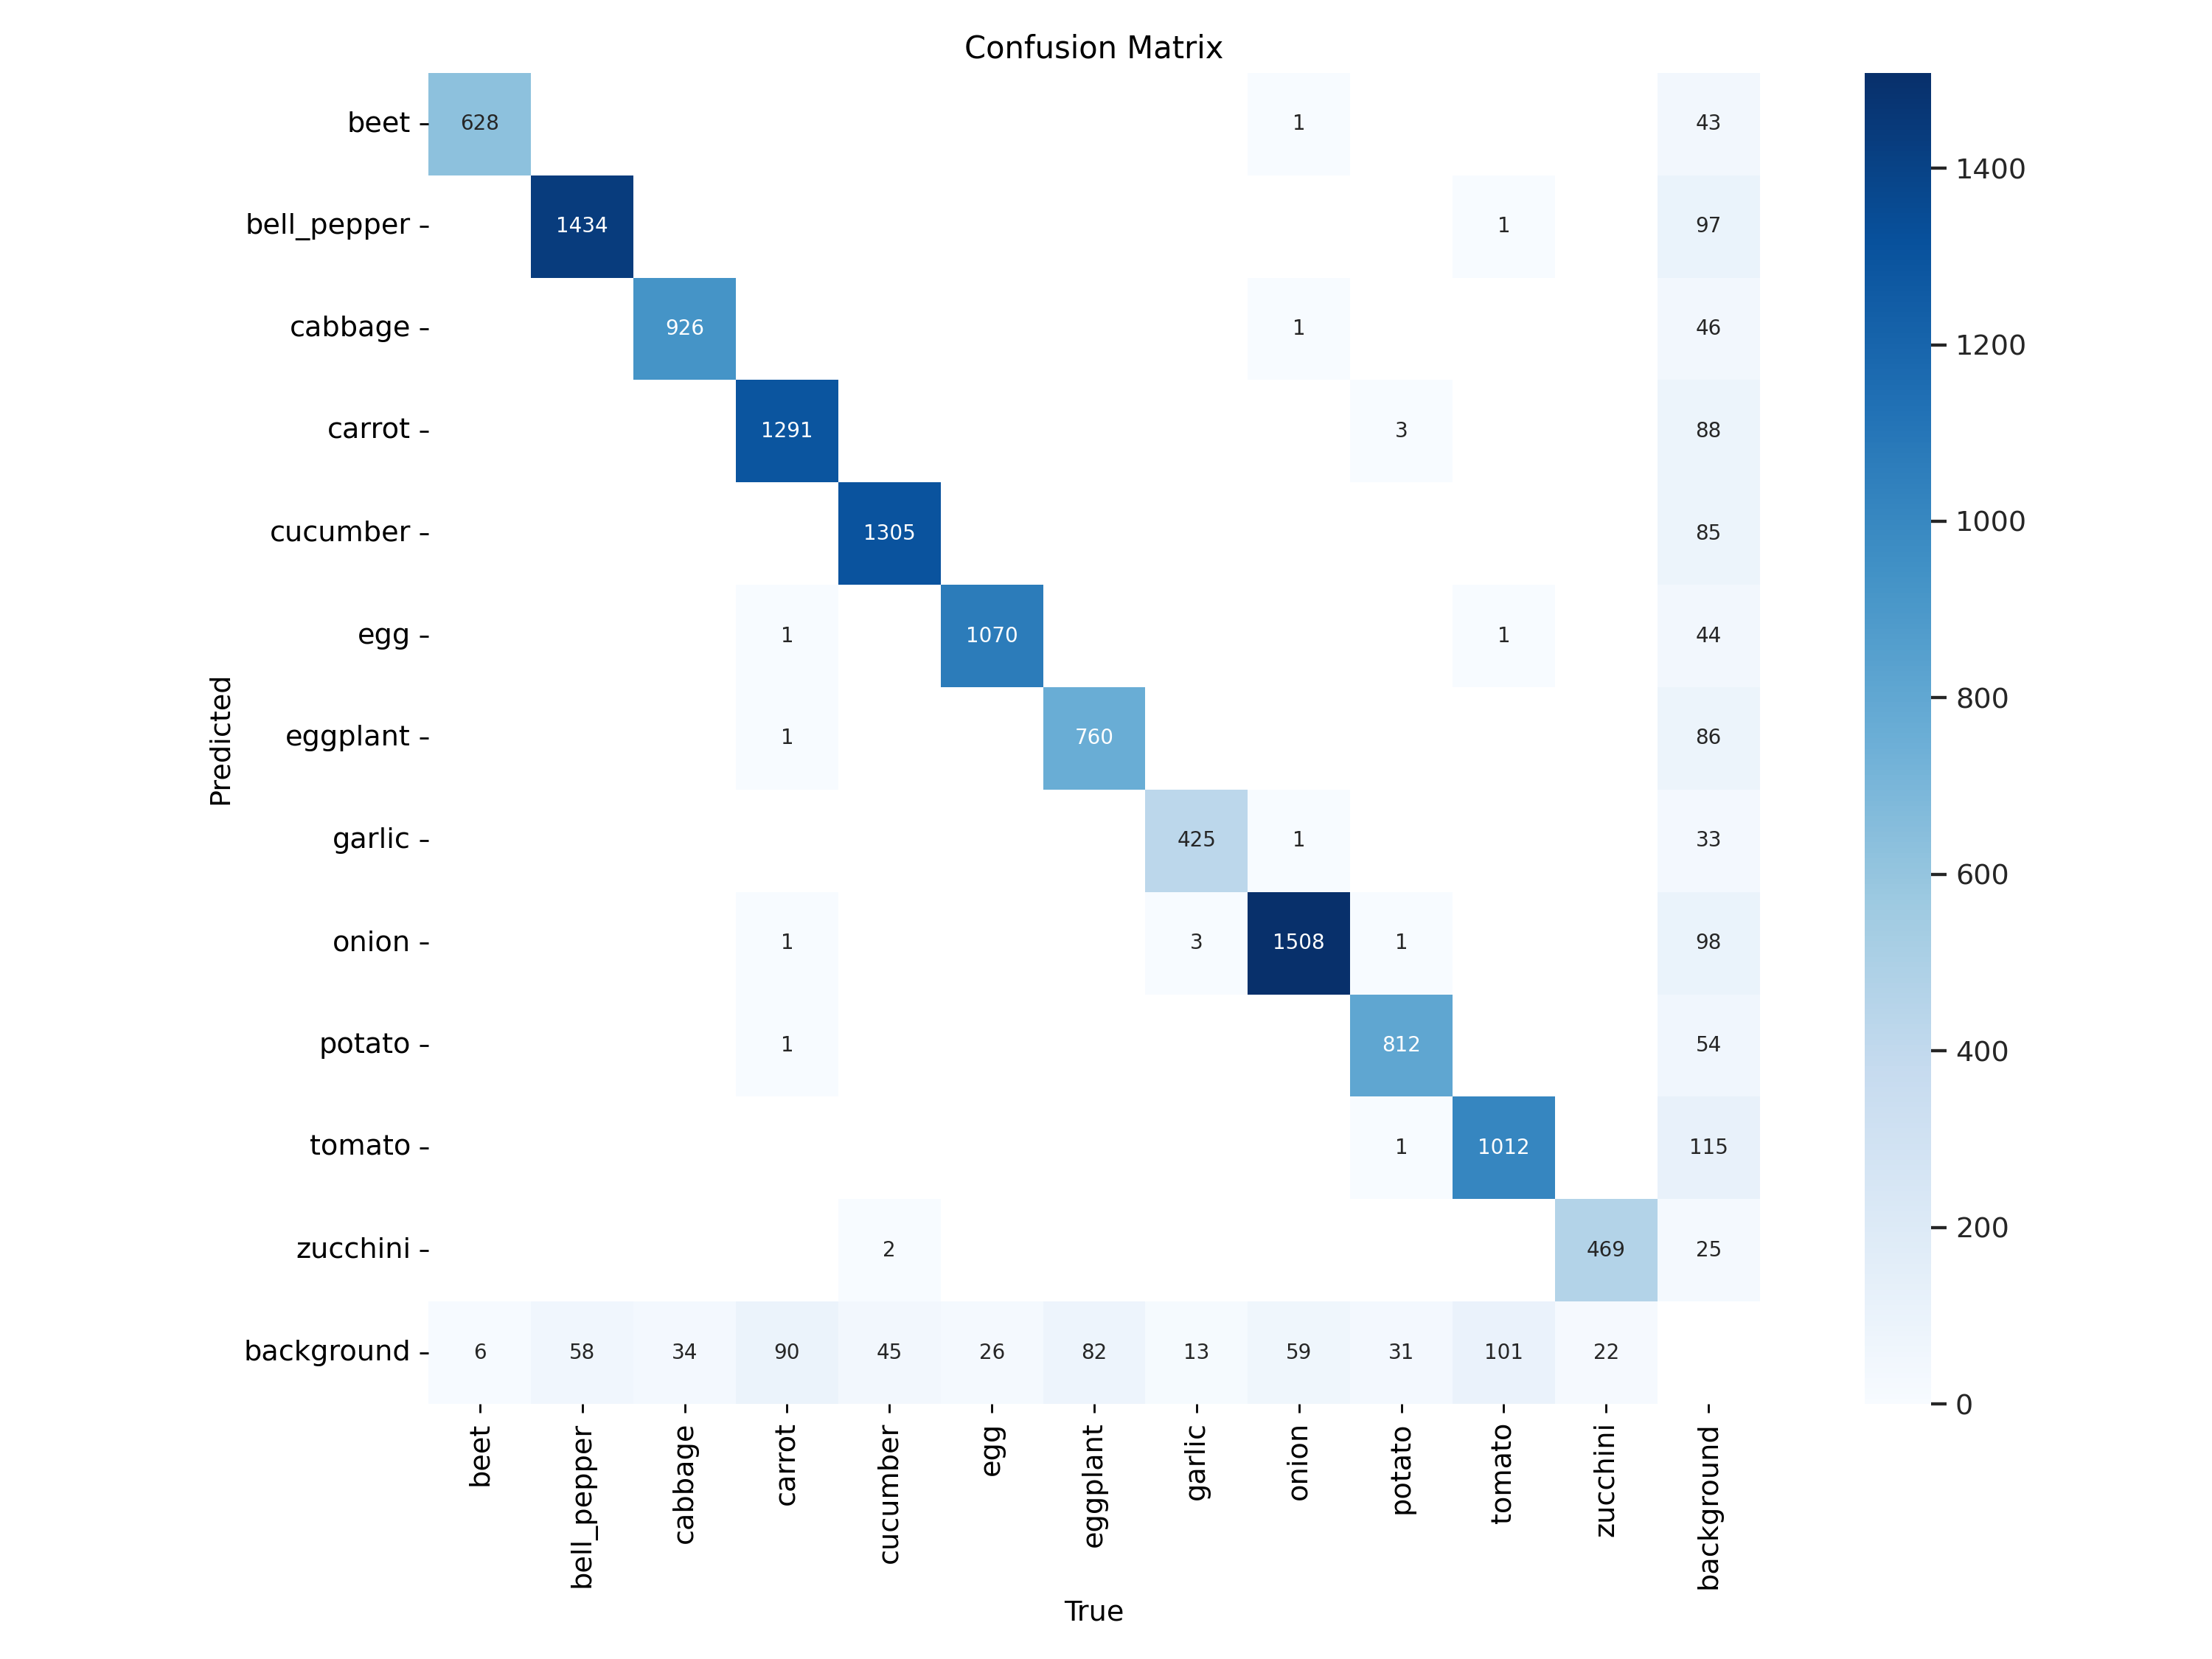

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


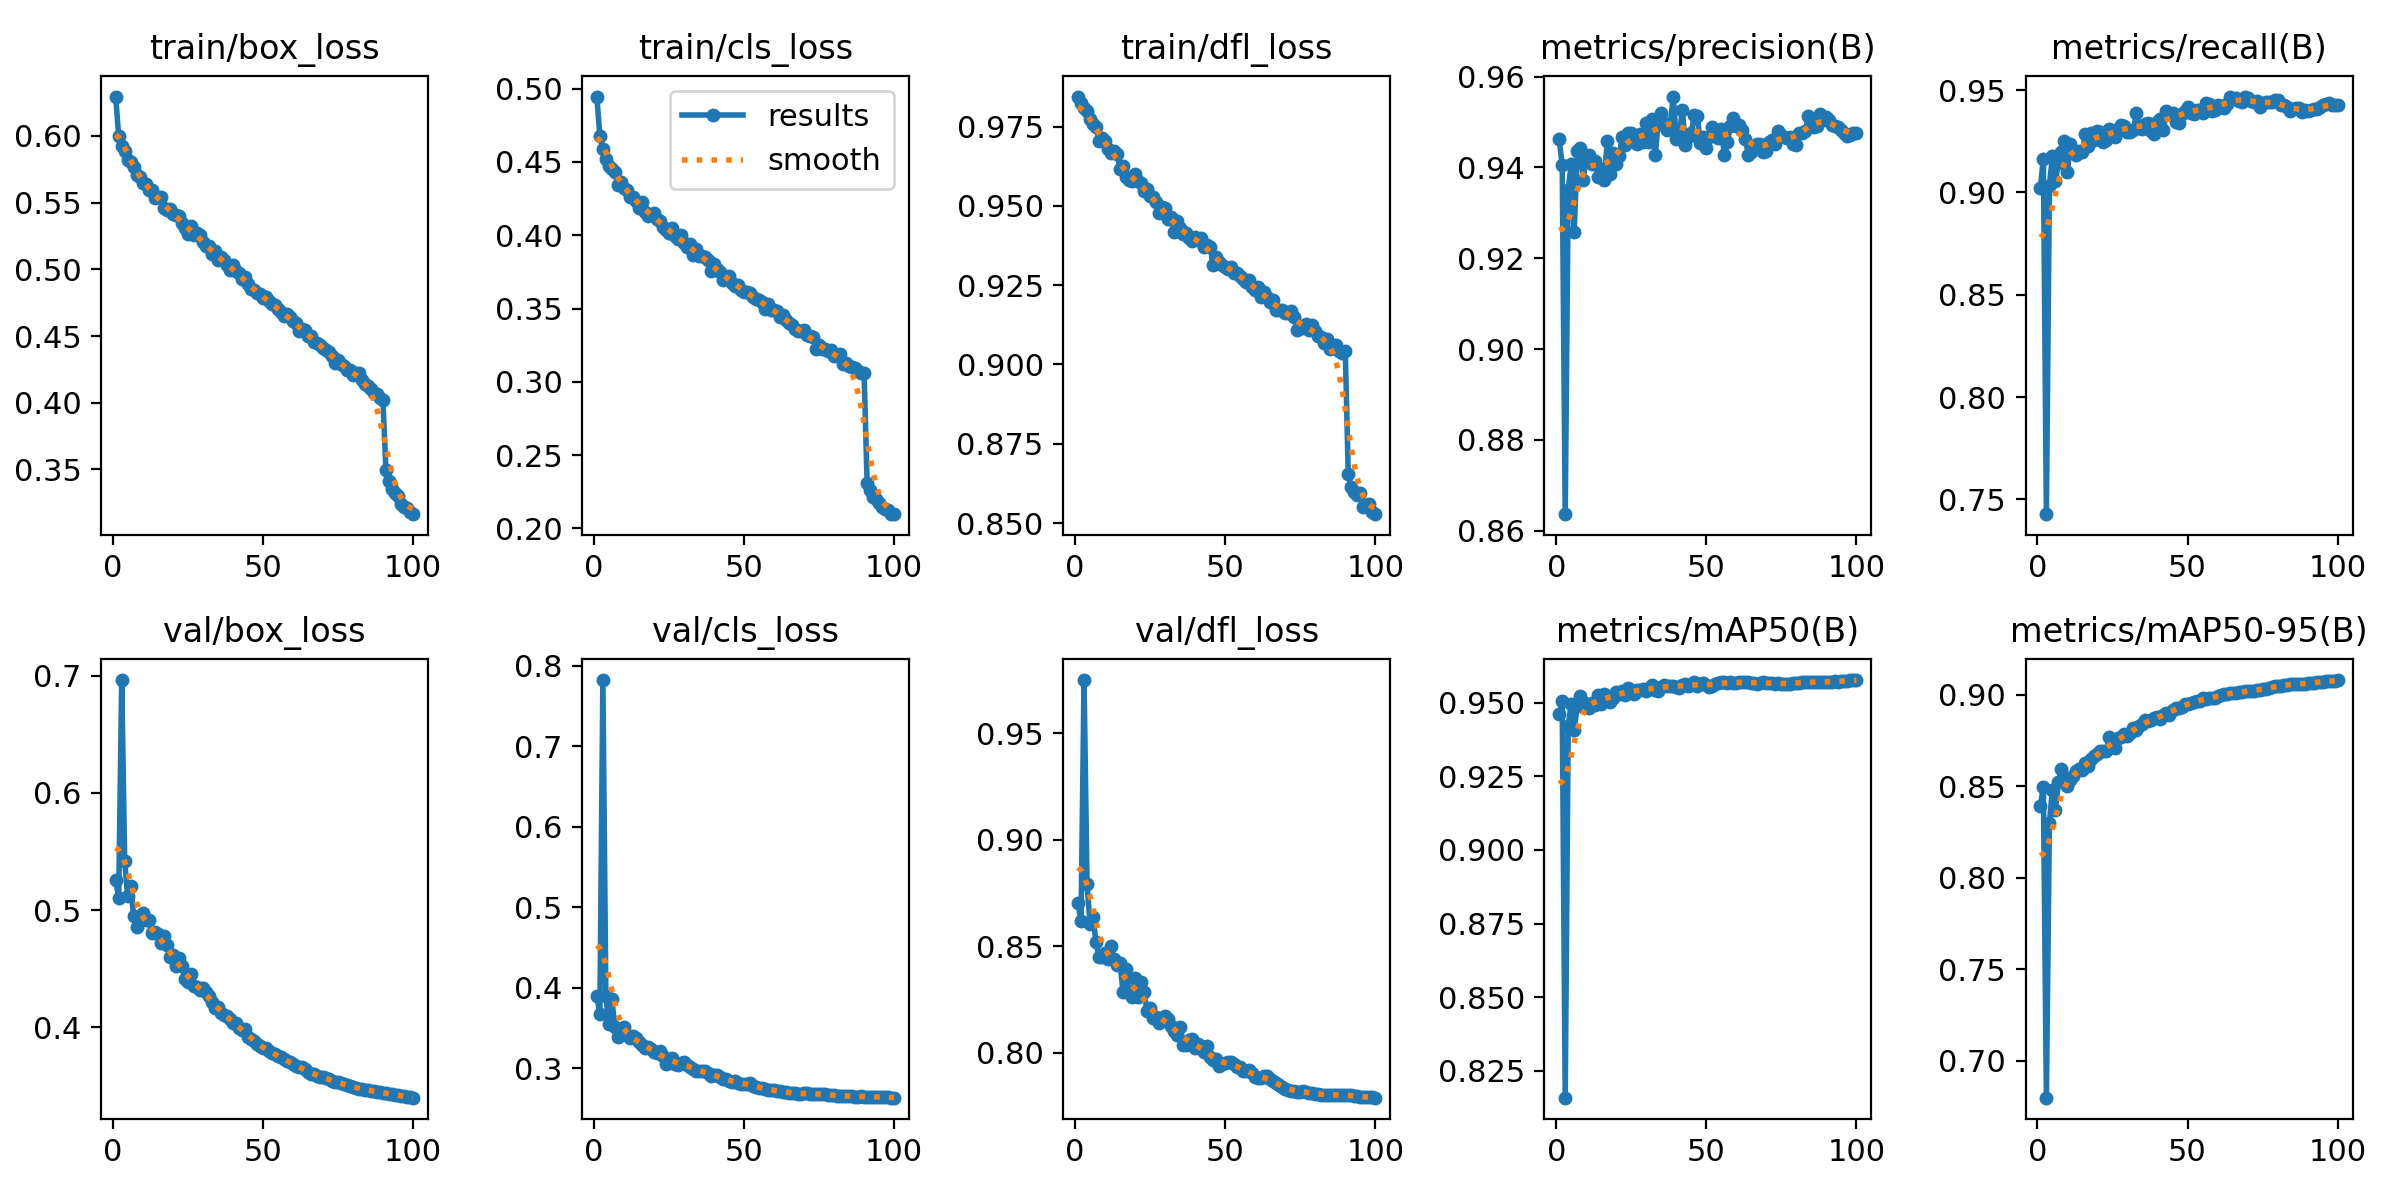

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


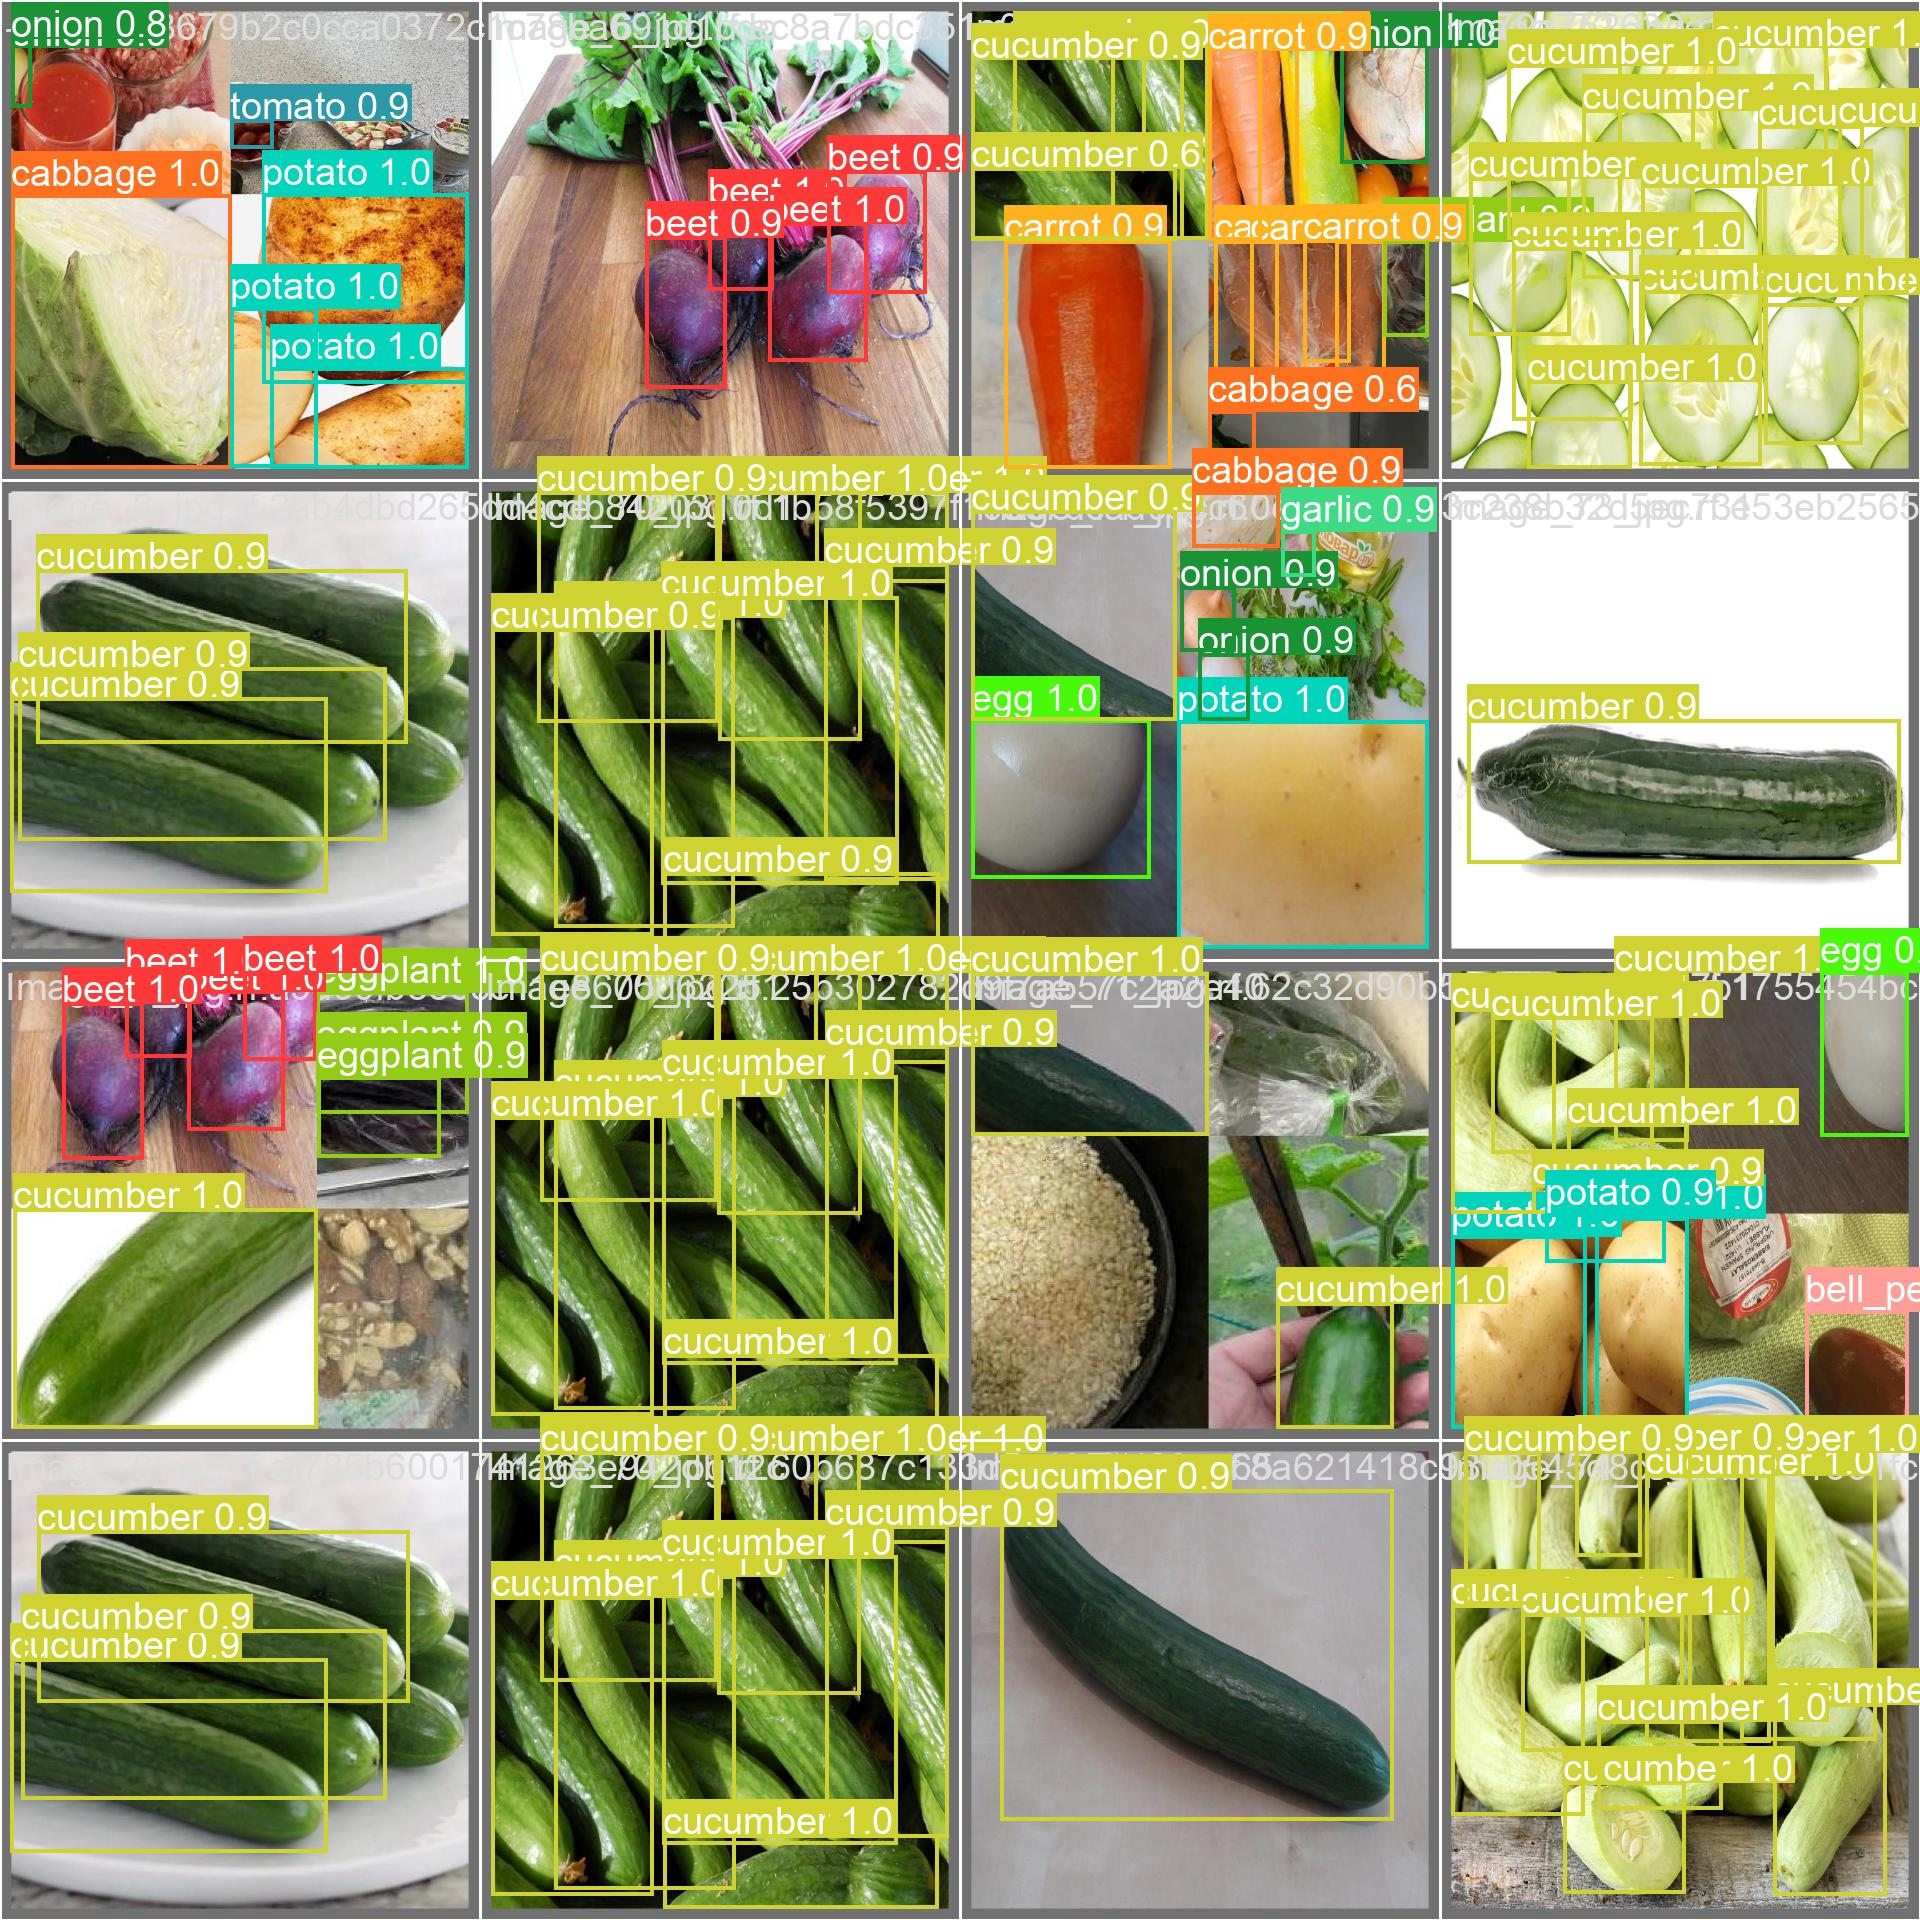

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [14]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data='datasets/data.yaml'

/content
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11130228 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 2487 images, 68 backgrounds, 0 corrupt: 100% 2487/2487 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 368, len(boxes) = 12226. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 156/156 [00:34<00:00,  4.52it/s]
                   all       2487      12226      0.948      0.943      0.957      0.908
                  beet       2487        634      0.951      0.976      0.992      0.952
           bell_pepper       2487       1492      0.951      0.957      0.963      0.917
               cabbage       